# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [134]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [135]:
X = data
y = target

In [136]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.9427195799268

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """

    mean_preds = np.zeros(len(y), dtype=float)
    mean_square_preds = np.zeros(len(y), dtype=float)
    hits_ct = np.zeros(len(y))
    error = 0.0
    mask = np.zeros(len(X), dtype=bool)

    for _ in range(num_runs):
        idx = np.random.choice(np.arange(len(X)), size=len(X))
        mask[idx] = True

        preds = regressor.fit(X[mask], y[mask]).predict(X[~mask])

        mean_preds[~mask] += preds
        mean_square_preds[~mask] += preds ** 2
        hits_ct[~mask] += 1

        error += ((preds - y[~mask]) ** 2).sum()
        mask[idx] = False

    hit_mask = hits_ct > 0
    mean_preds[hit_mask] /= hits_ct[hit_mask]
    mean_square_preds[hit_mask] /= hits_ct[hit_mask]

    bias = ((mean_preds[hit_mask] - y[hit_mask]) ** 2).mean()
    variance = (mean_square_preds[hit_mask] - mean_preds[hit_mask] ** 2).mean()
    error /= hits_ct.sum()
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print(f'Linear regression: bias: {bias:.3f}, variance: {variance:.3f}, error: {error:.3f}')
bias, variance, error = compute_biase_variance(DecisionTreeRegressor(random_state=42), X, y)
print(f'Decision tree:     bias: {bias:.3f}, variance: {variance:.3f}, error: {error:.3f}')
bias, variance, error = compute_biase_variance(RandomForestRegressor(random_state=42), X, y)
print(f'Random forest:     bias: {bias:.3f}, variance: {variance:.3f}, error: {error:.3f}')

Linear regression: bias: 23.712, variance: 0.584, error: 24.406
Decision tree:     bias: 10.340, variance: 12.378, error: 22.627
Random forest:     bias: 11.155, variance: 1.488, error: 12.590


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

**Ответ:<br>
В целом выглядит похожим на правду, то что ошибка это смещение + разброс.<br>
У линрега большое смещение, но так как эта модель менее склонна переобучаться и оверфиттиться, у нее низкий разброс.<br>
У решающих деревьев смещение поменьше, чем у линрега, но выше разброс. Если бы мы сделали большую глубину для деревьев, то смещение можно было бы уменьшать к 0 (потому что мы бы по факту запомнили обучающую выборку), при этом увеличивая разброс. С переобучением то же самое, как у линрега.<br>
Когда мы используем случайный лес, то делаем бэггинг над деревьями. Про него мы знаем, что смещение у него будет такое же, как и у стандартной модели, при этом разброс сильно уменьшается при некоррелированности данных.<br>
Судя по полученным данным, все более менее совпадает с реальностью.**

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [10]:
from sklearn.ensemble import BaggingRegressor


bias, variance, error = compute_biase_variance(BaggingRegressor(LinearRegression(), random_state=42), X, y)
print(f'Linreg bagging: bias: {bias:.3f}, variance: {variance:.3f}, error: {error:.3f}')
bias, variance, error = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor(random_state=42), random_state=42), X, y)
print(f'Tree bagging:   bias: {bias:.3f}, variance: {variance:.3f}, error: {error:.3f}')
bias, variance, error = compute_biase_variance(BaggingRegressor(RandomForestRegressor(random_state=42), random_state=42), X, y)
print(f'Forest bagging: bias: {bias:.3f}, variance: {variance:.3f}, error: {error:.3f}')

Linreg bagging: bias: 23.667, variance: 0.722, error: 24.310
Tree bagging:   bias: 10.997, variance: 2.678, error: 13.737
Forest bagging: bias: 12.631, variance: 0.843, error: 13.415


**Ответ:<br>
Как уже написал выше, бэггинг сохраняет смещение базовой модели и уменьшает разброс в $n$ раз, если данные не коррелируют.<br>
Линрег: Смещение то же самое, разброс кажется вырос (но возможно это просто артефакт), предположу что это потому что линейные модели кореллируют.<br>
Решающие деревья: Бэггинг очевидно сделал то, что и предполагалось - смещение базовой модели, разброс сильно снизился (так как деревья плохо кореллируют, учитывая что они обучаются на разных данных)<br>
Случайный лес: Сколько бэггинг к бэггингу не применяй, вряд ли станет лучше. Тут выходит примерно обычный случайный лес, поэтому его результаты слабо изменились.**

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [99]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=None):
    """
    plot graphics described above
    """

    mask = np.zeros(len(X), dtype=bool)
    mask[np.random.randint(len(X), size=num_test_objects)] = True

    x_train = X[~mask]
    y_train = y[~mask]
    x_test = X[mask]
    y_test = y[mask]

    preds = np.zeros((num_runs, num_test_objects))

    for i in range(num_runs):
        idx = np.random.choice(np.arange(len(x_train)), size=len(x_train))
        preds[i] = regressor.fit(x_train[idx], y_train[idx]).predict(x_test)

    ax.scatter(list(np.arange(num_test_objects)) * num_runs, preds.ravel(), s=1)
    ax.scatter(list(np.arange(num_test_objects)), y_test, s=10, c='black')
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Object number', fontsize=10)
    ax.set_ylabel('Prediction', fontsize=10)
    ax.set(ylim=(0, 50))

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

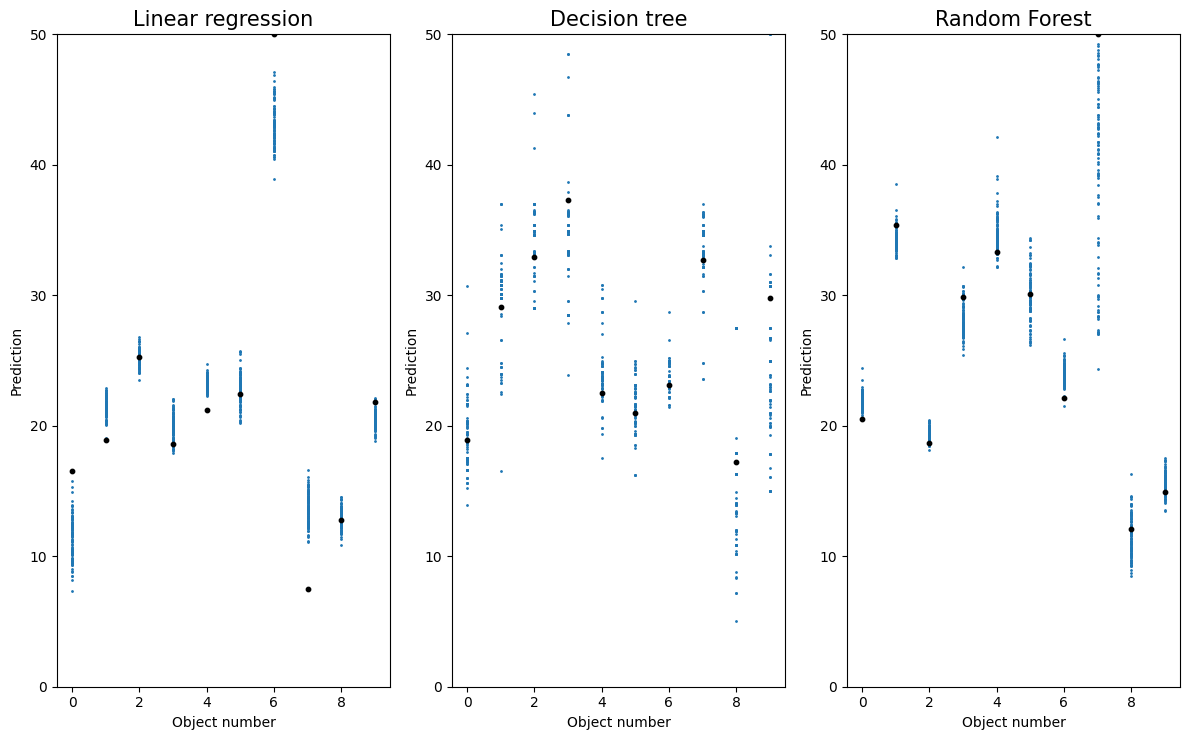

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 7.5))
plot_predictions(LinearRegression(), X, y, title='Linear regression', ax=ax1)
plot_predictions(DecisionTreeRegressor(random_state=42), X, y, title='Decision tree', ax=ax2)
plot_predictions(RandomForestRegressor(random_state=42), X, y, title='Random Forest', ax=ax3)
plt.tight_layout()
plt.show()

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Ответ: Линрег показывает высокое смещение и маленький (относительно) разброс. Деревья получают меньшее смещение (лучше делаем предсказания), но выше разброс. Лес совмещает лучшие стороны линрега и деревьев - у него разброс приемлемый и смещение не такое большое.**

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [161]:
depths = np.arange(1, 11)
features = np.arange(1, X.shape[1] + 1)
biases = np.zeros((len(depths), len(features)))
variances = np.zeros((len(depths), len(features)))

for depth in depths:
    for feature in features:
        bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(random_state=42, max_depth=depth, max_features=feature), X, y)
        biases[depth - 1][feature - 1] = bias
        variances[depth - 1][feature - 1] = variance

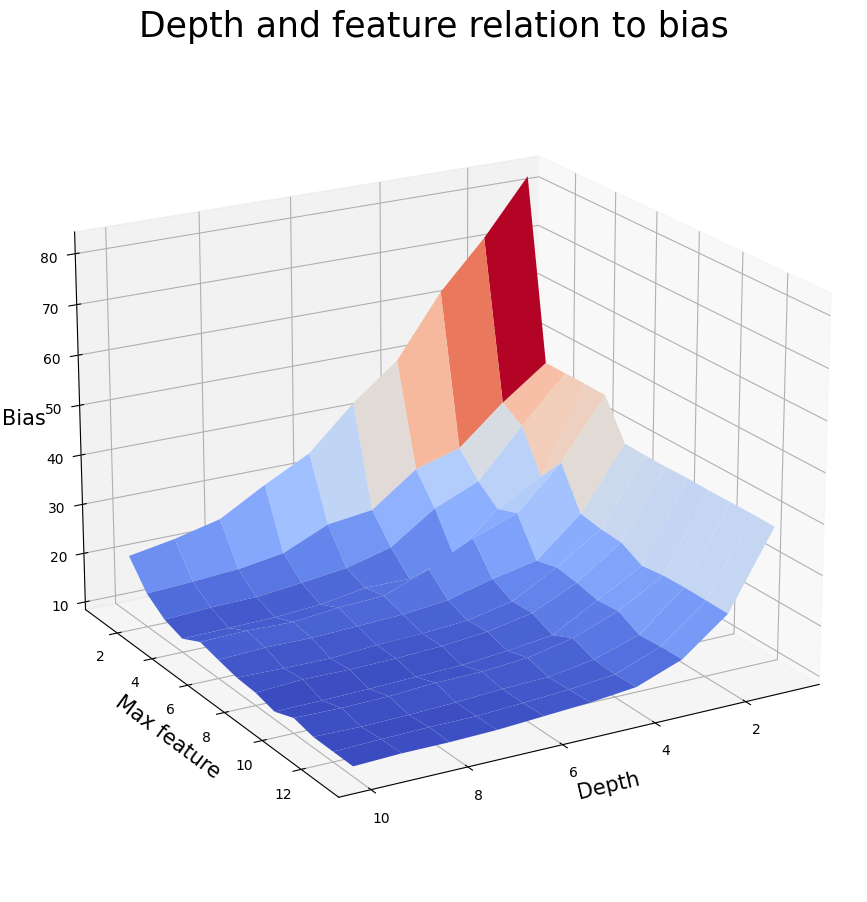

In [162]:
from matplotlib import cm


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(11, 11))
x_val, y_val = np.meshgrid(depths, features)
surf = ax.plot_surface(x_val, y_val, np.transpose(biases), cmap=cm.coolwarm, linewidth=0)

ax.set_title('Depth and feature relation to bias', fontsize=25)
ax.set_xlabel('Depth', fontsize=15)
ax.set_ylabel('Max feature', fontsize=15)
ax.set_zlabel('Bias', fontsize=15)
ax.view_init(azim=60, elev=20)

plt.show()

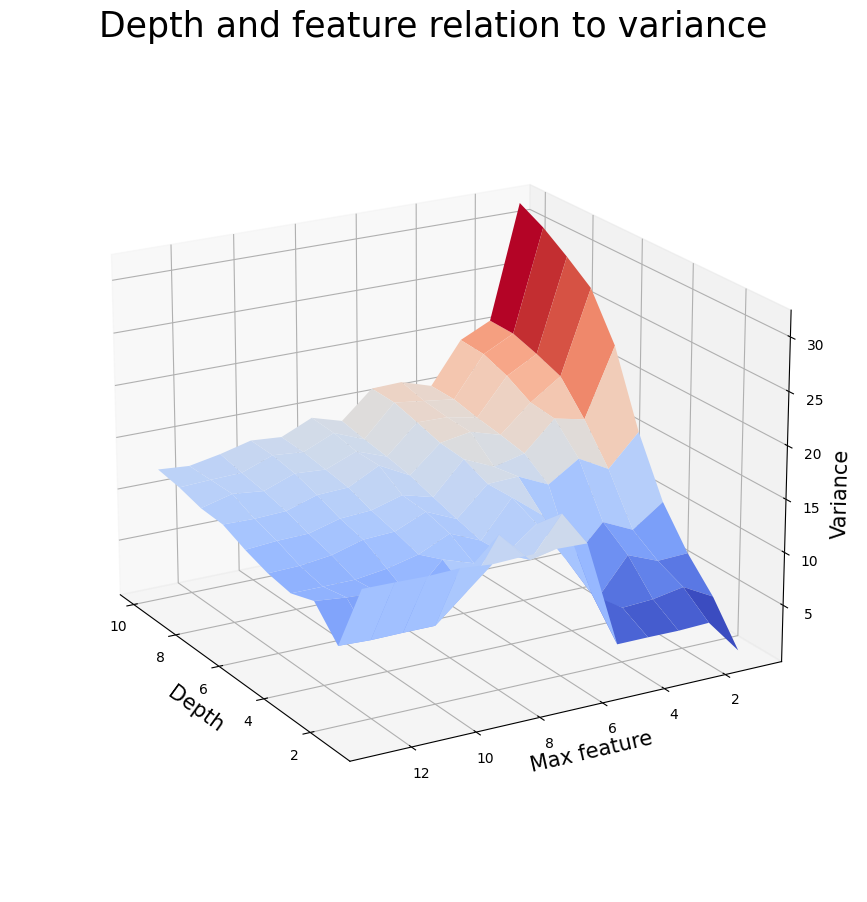

In [163]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(11, 11))
surf = ax.plot_surface(x_val, y_val, np.transpose(variances), cmap=cm.coolwarm, linewidth=0)

ax.set_title('Depth and feature relation to variance', fontsize=25)
ax.set_xlabel('Depth', fontsize=15)
ax.set_ylabel('Max feature', fontsize=15)
ax.set_zlabel('Variance', fontsize=15)
ax.view_init(azim=150, elev=20)
ax.set_box_aspect(aspect=None, zoom=0.9)
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [169]:
n_estimators = 2 ** np.arange(1, 9) # для 10 считалось больше часа, поэтому снизил до 9
biases = []
variances = []

for n_estimator in n_estimators:
    print(n_estimator)
    bias, variance, _ = compute_biase_variance(RandomForestRegressor(random_state=42, n_estimators=n_estimator), X, y)
    biases += [bias]
    variances += [variance]

2
4
8
16
32
64
128
256


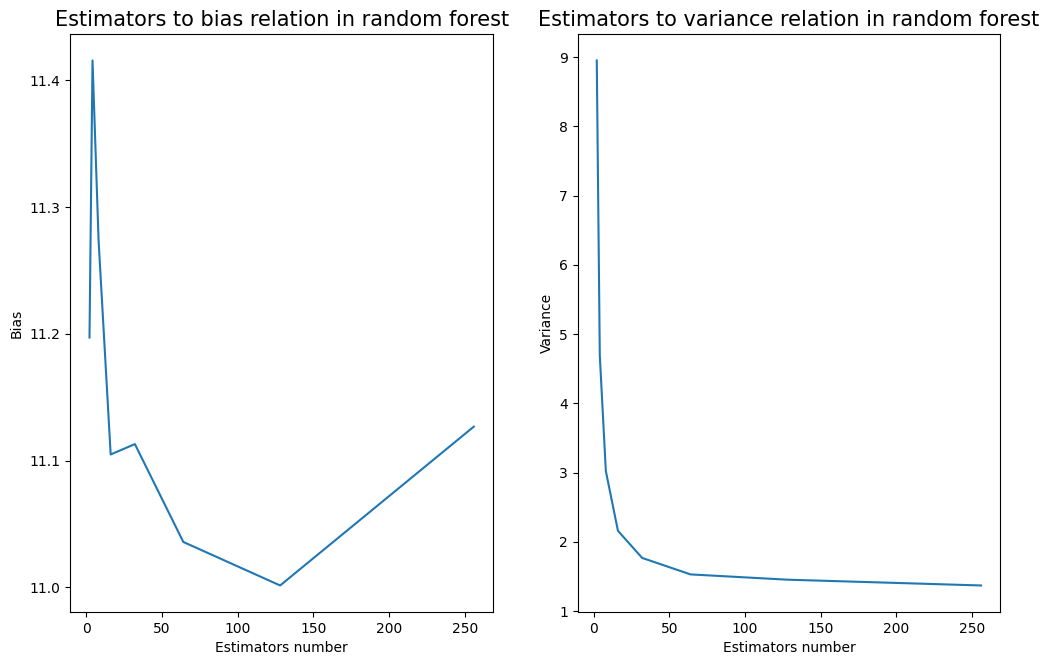

In [170]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 7.5))

ax1.plot(list(n_estimators), biases);
ax1.set_title('Estimators to bias relation in random forest', fontsize=15)
ax1.set_xlabel('Estimators number', fontsize=10)
ax1.set_ylabel('Bias', fontsize=10)

ax2.plot(list(n_estimators), variances);
ax2.set_title('Estimators to variance relation in random forest', fontsize=15)
ax2.set_xlabel('Estimators number', fontsize=10)
ax2.set_ylabel('Variance', fontsize=10)

plt.show()

In [174]:
from sklearn.ensemble import GradientBoostingRegressor


n_estimators = 2 ** np.arange(1, 10)
biases = []
variances = []

for n_estimator in n_estimators:
    print(n_estimator)
    bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(random_state=42, n_estimators=n_estimator), X, y)
    biases += [bias]
    variances += [variance]

2
4
8
16
32
64
128
256
512


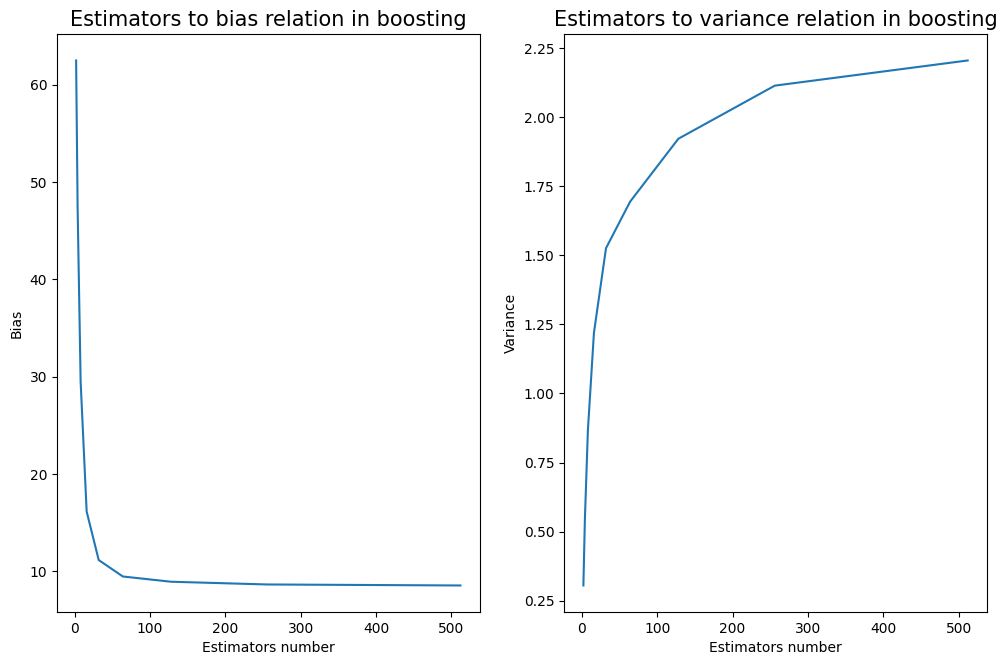

In [175]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 7.5))

ax1.plot(list(n_estimators), biases);
ax1.set_title('Estimators to bias relation in boosting', fontsize=15)
ax1.set_xlabel('Estimators number', fontsize=10)
ax1.set_ylabel('Bias', fontsize=10)

ax2.plot(list(n_estimators), variances);
ax2.set_title('Estimators to variance relation in boosting', fontsize=15)
ax2.set_xlabel('Estimators number', fontsize=10)
ax2.set_ylabel('Variance', fontsize=10)

plt.show()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

**Ответ: В случайном лесе количество базовых моделей обратно пропорционально разбросу, что видно на графиках. Смещение в теории константное, получилось с какими то колебаниями (скорее всего опять рандом стейт).<br>
Для бустинга большее количество моделей должно уменьшать смещение, так как мы будем пытаться уменьшить ошибку, что приведет нас позже к переобучению (из-за количества моделей), в целом похоже на полученные графики.**

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

<img width="800" src=" 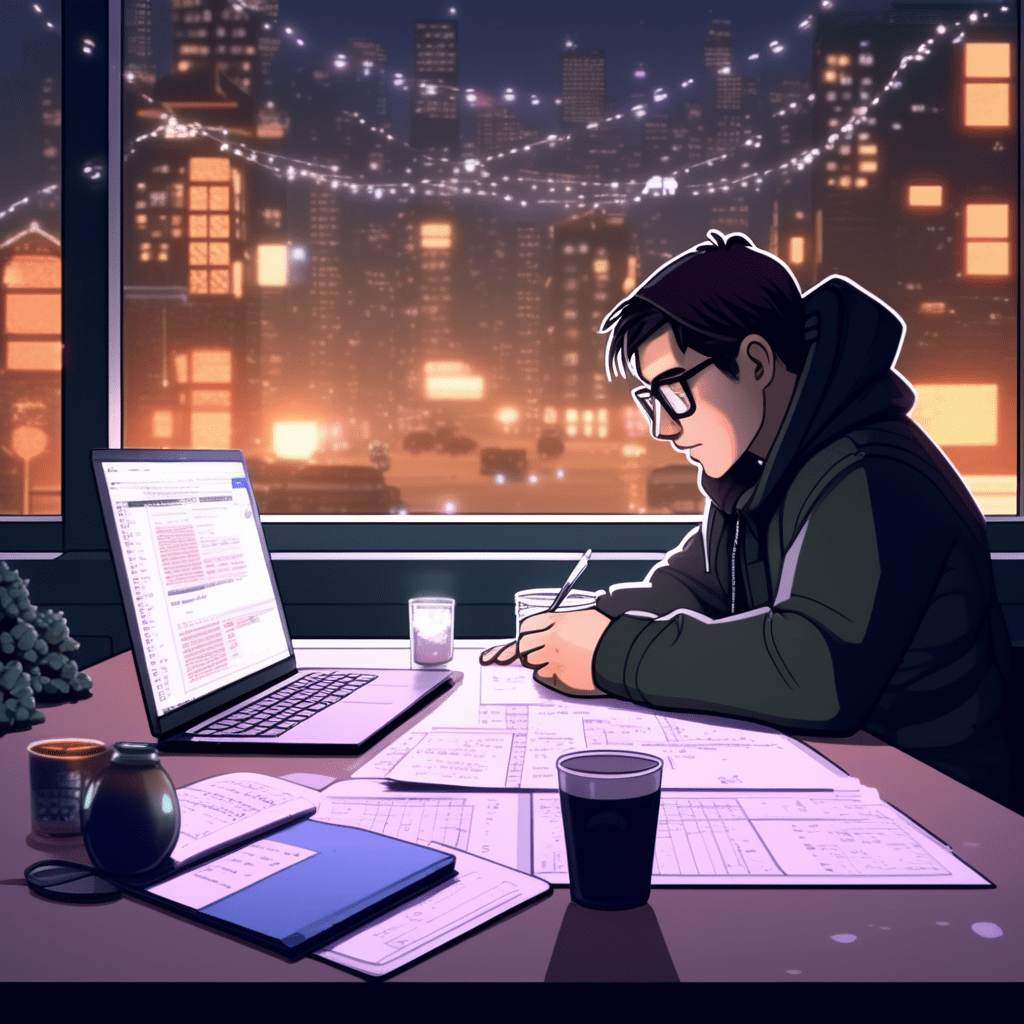" />